# Image similarity estimation using a Siamese Network with a triplet loss

**Authors:** [Hazem Essam](https://twitter.com/hazemessamm) and [Santiago L. Valdarrama](https://twitter.com/svpino)<br>
**Date created:** 2021/03/25<br>
**Last modified:** 2021/03/25<br>
**Description:** Training a Siamese Network to compare the similarity of images using a triplet loss function.

## Introduction

A [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network) is a type of network architecture that
contains two or more identical subnetworks used to generate feature vectors for each input and compare them.

Siamese Networks can be applied to different use cases, like detecting duplicates, finding anomalies, and face recognition.

This example uses a Siamese Network with three identical subnetworks. We will provide three images to the model, where
two of them will be similar (_anchor_ and _positive_ samples), and the third will be unrelated (a _negative_ example.)
Our goal is for the model to learn to estimate the similarity between images.

For the network to learn, we use a triplet loss function. You can find an introduction to triplet loss in the
[FaceNet paper](https://arxiv.org/pdf/1503.03832.pdf) by Schroff et al,. 2015. In this example, we define the triplet
loss function as follows:

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

This example uses the [Totally Looks Like dataset](https://sites.google.com/view/totally-looks-like-dataset)
by [Rosenfeld et al., 2018](https://arxiv.org/pdf/1803.01485v3.pdf).

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

target_shape = (100, 100)
!python --version

Python 3.8.5


## Load the dataset

We are going to load the *Totally Looks Like* dataset and unzip it inside the `~/.keras` directory
in the local environment.

The dataset consists of two separate files:

* `left.zip` contains the images that we will use as the anchor.
* `right.zip` contains the images that we will use as the positive sample (an image that looks like the anchor).

In [51]:
cache_dir = Path(Path.home()) / "Downloads" / "t4"
anchor_images_path = cache_dir / "iml-images_anchor"
positive_images_path = cache_dir / "iml-images_positive"
negative_images_path = cache_dir / "iml-images_negative"
negative_images_path

WindowsPath('C:/Users/Luca Entremont/Downloads/t4/iml-images_negative')

## Preparing the data

We are going to use a `tf.data` pipeline to load the data and generate the triplets that we
need to train the Siamese network.

We'll set up the pipeline using a zipped list with anchor, positive, and negative filenames as
the source. The pipeline will load and preprocess the corresponding images.

In [2]:

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


Let's setup our data pipeline using a zipped list with an anchor, positive,
and negative image filename as the source. The output of the pipeline
contains the same triplet with every image loaded and preprocessed.

In [54]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
N_ALL = len(os.listdir(anchor_images_path))
N_IMAGES = int(N_ALL)

anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)[:N_IMAGES]]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)[:N_IMAGES]]
)

negative_images = sorted(
    [str(negative_images_path / f) for f in os.listdir(negative_images_path)[:N_IMAGES]]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


Let's take a look at a few examples of triplets. Notice how the first two images
look alike while the third one is always different.

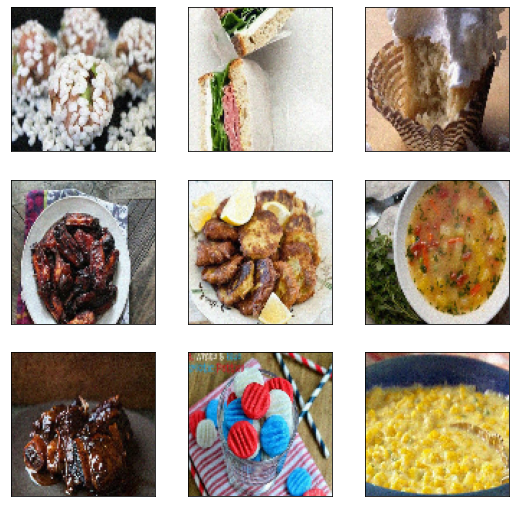

In [105]:

def visualize(anchor, positive, negative, n=3):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(n,3)
    for i in range(n):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Setting up the embedding generator model

Our Siamese Network will generate embeddings for each of the images of the
triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and
connect a few `Dense` layers to it so we can learn to separate these
embeddings.

We will freeze the weights of all the layers of the model up until the layer `conv5_block1_out`.
This is important to avoid affecting the weights that the model has already learned.
We are going to leave the bottom few layers trainable, so that we can fine-tune their weights
during training.

In [3]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

KeyboardInterrupt: 

## Setting up the Siamese Network model

The Siamese network will receive each of the triplet images as an input,
generate the embeddings, and output the distance between the anchor and the
positive embedding, as well as the distance between the anchor and the negative
embedding.

To compute the distance, we can use a custom layer `DistanceLayer` that
returns both values as a tuple.

In [0]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

## Putting everything together

We now need to implement a model with custom training loop so we can compute
the triplet loss using the three embeddings produced by the Siamese network.

Let's create a `Mean` metric instance to track the loss of the training process.

In [0]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


## Training

We are now ready to train our model.

In [59]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
1488/1488 [==============================] - 2840s 2s/step - loss: 0.4805 - val_loss: 0.4610
Epoch 2/10
1488/1488 [==============================] - 2802s 2s/step - loss: 0.4649 - val_loss: 0.4596
Epoch 3/10
1488/1488 [==============================] - 2785s 2s/step - loss: 0.4493 - val_loss: 0.4521
Epoch 4/10
1488/1488 [==============================] - 2789s 2s/step - loss: 0.4304 - val_loss: 0.4301
Epoch 5/10
1488/1488 [==============================] - 2767s 2s/step - loss: 0.4148 - val_loss: 0.4256
Epoch 6/10
1488/1488 [==============================] - 2766s 2s/step - loss: 0.4025 - val_loss: 0.4120
Epoch 7/10
1488/1488 [==============================] - 2732s 2s/step - loss: 0.3845 - val_loss: 0.3952
Epoch 8/10
1488/1488 [==============================] - 2721s 2s/step - loss: 0.3637 - val_loss: 0.3904
Epoch 9/10
1488/1488 [==============================] - 2713s 2s/step - loss: 0.3473 - val_loss: 0.3828
Epoch 10/10
1488/1488 [==============================] - 2865s 2

## Inspecting what the network has learned

At this point, we can check how the network learned to separate the embeddings
depending on whether they belong to similar images.

We can use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to measure the
similarity between embeddings.

Let's pick a sample from the dataset to check the similarity between the
embeddings generated for each image.

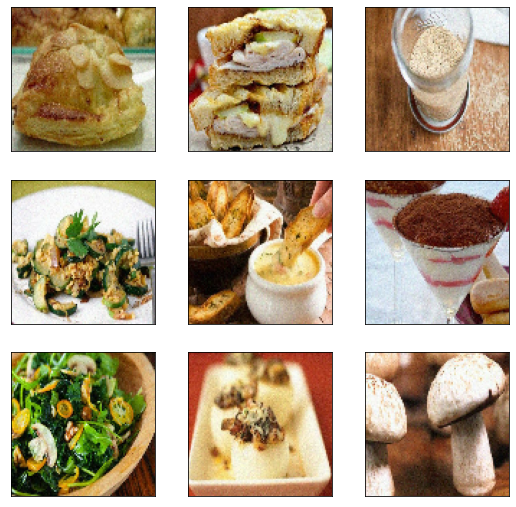

In [69]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

Finally, we can compute the cosine similarity between the anchor and positive
images and compare it with the similarity between the anchor and the negative
images.

We should expect the similarity between the anchor and positive images to be
larger than the similarity between the anchor and the negative images.

In [88]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.99982834
Negative similarity 0.99978817


Case:  0  of  590


InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

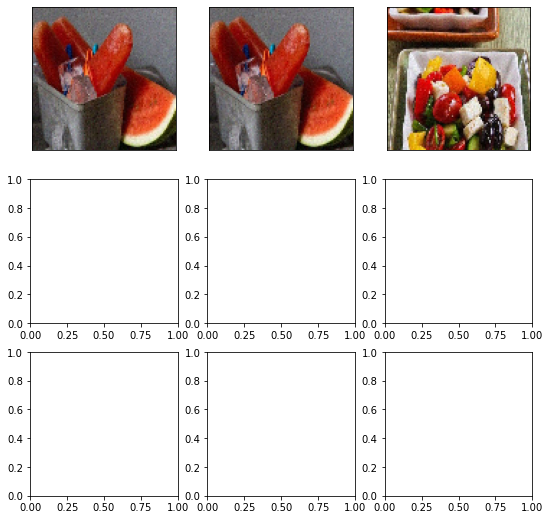

In [113]:
file_test = open('train_triplets.txt', 'r').readlines()[:590]
#file_test = ['02461 03450 02678']
result = []
max = len(file_test)
for e,line in enumerate(file_test):
    if e%10 == 0:
        print("Case: ", e, " of ", max)
    nums = [x.strip() for x in line.split(' ')]
    nums[1] = nums[0]
    paths = [cache_dir / "food" / f"{x}.jpg" for x in nums]
    datasets_test = [tf.data.Dataset.from_tensor_slices([str(x)]) for x in paths]
    dataset_test = tf.data.Dataset.zip((datasets_test[0], datasets_test[1], datasets_test[2]))
    dataset_test = dataset_test.map(preprocess_triplets)
    dataset_test = dataset_test.batch(32, drop_remainder=False)
    #dataset_test = dataset_test.prefetch(8)
    #print("DTEST ",dataset_test)
    samp =  next(iter(dataset_test))
    visualize(*samp)
    #print("SAMP ",samp)
    im1, im2, im3 = samp
    im1_embedding, im2_embedding, im3_embedding = (
        embedding(resnet.preprocess_input(im1)),
        embedding(resnet.preprocess_input(im2)),
        embedding(resnet.preprocess_input(im3)),
    )
    
    im12_similarity = cosine_similarity(im1_embedding, im2_embedding)
    sim12 = im12_similarity.numpy()
    #print("similarity 1:", sim12)

    im13_similarity = cosine_similarity(im1_embedding, im3_embedding)
    sim13 = im13_similarity.numpy()
    #print("1 against 2: ", sim12)
    #print("1 against 3: ", sim13)
    #print("similarity 2", sim13)
    res = int(sim12 > sim13)
    print("Result: " , res)
    result.append(res)
result    

## Summary

1. The `tf.data` API enables you to build efficient input pipelines for your model. It is
particularly useful if you have a large dataset. You can learn more about `tf.data`
pipelines in [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data).

2. In this example, we use a pre-trained ResNet50 as part of the subnetwork that generates
the feature embeddings. By using [transfer learning](https://www.tensorflow.org/guide/keras/transfer_learning?hl=en),
we can significantly reduce the training time and size of the dataset.

3. Notice how we are [fine-tuning](https://www.tensorflow.org/guide/keras/transfer_learning?hl=en#fine-tuning)
the weights of the final layers of the ResNet50 network but keeping the rest of the layers untouched.
Using the name assigned to each layer, we can freeze the weights to a certain point and keep the last few layers open.

4. We can create custom layers by creating a class that inherits from `tf.keras.layers.Layer`,
as we did in the `DistanceLayer` class.

5. We used a cosine similarity metric to measure how to 2 output embeddings are similar to each other.

6. You can implement a custom training loop by overriding the `train_step()` method. `train_step()` uses
[`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape),
which records every operation that you perform inside it. In this example, we use it to access the
gradients passed to the optimizer to update the model weights at every step. For more details, check out the
[Intro to Keras for researchers](https://keras.io/getting_started/intro_to_keras_for_researchers/)
and [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=en).

In [63]:
result = [str(int(x)) for x in result]
import csv

#with open('./result2_trashh.csv', 'w') as myfile:
#    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#    wr.writerow(result)

In [64]:
with open('./result4_bigg.txt', 'w') as f:
    for l in result:
        f.write(f"{l}\n")

In [89]:
result

[1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [115]:
siamese_model.predict(('00000','00000','00000'))

ValueError: in user code:

    C:\Users\Luca Entremont\anaconda3\envs\iml_task4\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    <ipython-input-58-6581cf0f6e0b>:18 call  *
        return self.siamese_network(inputs)
    C:\Users\Luca Entremont\anaconda3\envs\iml_task4\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Luca Entremont\anaconda3\envs\iml_task4\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\Luca Entremont\anaconda3\envs\iml_task4\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Luca Entremont\anaconda3\envs\iml_task4\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Luca Entremont\anaconda3\envs\iml_task4\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:3099 call
        return self._make_op(inputs)
    C:\Users\Luca Entremont\anaconda3\envs\iml_task4\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:3121 _make_op
        c_op = ops._create_c_op(graph, node_def, inputs, control_inputs=[])
    C:\Users\Luca Entremont\anaconda3\envs\iml_task4\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 1 and 3 for '{{node siamese_model_3/functional_7/tf_op_layer_BiasAdd_9/BiasAdd_9}} = BiasAdd[T=DT_FLOAT, _cloned=true, data_format="NHWC"](siamese_model_3/functional_7/tf_op_layer_strided_slice_9/strided_slice_9, siamese_model_3/functional_7/tf_op_layer_BiasAdd_9/BiasAdd_9/bias)' with input shapes: [?,1], [3].
